In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from os import listdir
from os.path import isfile, join

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_df=pd.read_csv('data/train.csv')
validation_df=pd.read_csv('data/validation.csv')
validation_df=pd.concat([train_df[-9:],validation_df])
validation_df=validation_df.reset_index(drop=True)
test_df=pd.read_csv('data/test.csv')
train_df.drop(['High price', 'Low Price', 'Date'],axis=1,inplace=True)
validation_df.drop(['High price', 'Low Price', 'Date'],axis=1,inplace=True)
test_df.drop(['High price', 'Low Price','Date'],axis=1,inplace=True)

In [4]:
class dataprep(Dataset):
    def __init__(self, dataframe):
        self.df=dataframe
    def __len__(self):
        return self.df.shape[0]-10
    def __getitem__(self,idx):
        if (idx+10<self.df.shape[0]):
            X=torch.from_numpy(self.df.drop('Closing Price',axis=1)[idx:idx+10].values)
            targets=torch.from_numpy(self.df['Closing Price'][idx:idx+9].values)
            y=torch.tensor([self.df['Closing Price'].loc[idx+9]])
            return ({'X':X, 'targets':targets, 'y': y})

In [5]:
train_set=dataprep(dataframe=train_df)
validation_set=dataprep(dataframe=validation_df)
test_set=dataprep(dataframe=test_df)

In [6]:
train_loader = DataLoader(train_set, batch_size=15, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self,encoder_input_size=16,encoder_hidden_size=64, time_steps=10):
        super(EncoderRNN,self).__init__()
        self.input_size=encoder_input_size
        #input_size=n
        self.hidden_size=encoder_hidden_size
        #hidden_size=1
        self.t_steps=time_steps
        #time_steps=10
        
        self.input_attention=nn.Linear(time_steps+encoder_hidden_size,1)
        self.rnn=nn.GRU(self.input_size, self.hidden_size)
        
    def forward(self,encoder_input,batch_size):
        #encoder_input:batch,T,n
        encoder_input=encoder_input.permute(0,2,1) #batch,n,T
        #print (encoder_input.size())
        hidden=self.initHidden(batch_size) #hidden : 1,batch,hidden_size
        #print (hidden.size())
        encoded = torch.zeros(batch_size, self.t_steps, self.hidden_size,device=device) #encoded: 1,T,hidden_size
        #print(encoded.size())
        for t in range(self.t_steps):
            x=torch.cat((hidden.repeat(self.input_size,1,1).permute(1,0,2),encoder_input),dim=2)
            #print (x.size())
            #x:batch,n,T+hidden_size
            x=x.view(-1,self.t_steps+self.hidden_size)
            #print (x.size())
            #x:batch*n,T+hidden_size
            x=F.softmax((self.input_attention(x)).view(-1,self.input_size),dim=1)
            #print (x.size())
            #print(encoder_input[:,t,:].size())
            #x:batch,n
            x=torch.mul(x,encoder_input[:,:,t])
            #print (x.size())
            #x:1,n
            output, hidden=self.rnn(x.unsqueeze(0), hidden)
            #print (output.size(), hidden.size())
            encoded[:,t,:]=hidden
            #output,hidden:1,1,hidden
        return encoded
    
    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self,decoder_hidden_size=64,encoder_hidden_size=64,decoder_input_size=1, time_steps=10):
        super(DecoderRNN,self).__init__()
        self.decoder_hidden_size=decoder_hidden_size
        self.encoder_hidden_size=encoder_hidden_size
        self.decoder_input_size=decoder_input_size
        self.t_steps=time_steps
        
        self.temporal_attention=nn.Linear(decoder_hidden_size+encoder_hidden_size, 1)
        self.rnn=nn.GRU(decoder_input_size,decoder_hidden_size)
        self.fc1 = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc2 = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)
        
    def forward(self,encoded,y_history,batch_size):
        #encoded: batch,T,hidden_size
        #print (encoded.size())
        
        #y_history: batch,T-1
        hidden=self.initHidden(batch_size) #hidden:1,batch,hidden_size
        #print (hidden.size())
        for t in range(self.t_steps):
            x=torch.cat((hidden.repeat(self.t_steps,1,1).permute(1,0,2), encoded), dim=2) 
            #x:batch,T,enc_hidden_size+dec_hidden_size
            x=F.softmax(self.temporal_attention(x.view(-1,self.decoder_hidden_size+self.encoder_hidden_size)).view(-1,self.t_steps), dim=1)
            #x:batch,T
            x=torch.bmm(x.unsqueeze(1), encoded)[:,0,:]
            #x:batch,hidden_size
            if (t < self.t_steps-1):
                y_tilda=self.fc1(torch.cat((x, y_history[:, t].unsqueeze(1)), dim=1))
                output, hidden=self.rnn(y_tilda.unsqueeze(0), hidden)
        y_pred=self.fc2(torch.cat((hidden[0], x), dim = 1))
            
        return y_pred
                
        
    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.decoder_hidden_size, device=device)
    

In [9]:
def test(encoder,decoder, test_loader, loss_criterion):
    eval_loss=0
    y_predicted=[]
    y_actual=[]
    with torch.no_grad():
        for i,sample in enumerate(test_loader):
            x=Variable(sample['X'].type(torch.cuda.FloatTensor))
            y=Variable(sample['targets'].type(torch.cuda.FloatTensor))
            y_true=Variable(sample['y'].type(torch.cuda.FloatTensor))
            encoded=encoder(x,1)
            y_pred=decoder(encoded,y,1)
        
            loss=loss_criterion(y_pred,y_true)
            eval_loss+=loss.item()
            y_predicted.append(y_pred.item())
            y_actual.append(y_true.item())
    
    return eval_loss, y_predicted, y_actual

In [10]:
def pp(y_pred,y_true):
    r=0
    for t in range(0,len(y_pred)-1):
        if((y_pred[t+1]>y_pred[t] and y_true[t+1]>y_true[t]) or (y_pred[t+1]<y_pred[t] and y_true[t+1]<y_true[t])):
            r=r+1
    return r/len(y_pred)

In [11]:
def cdr(y_pred,y_true):
    r=0
    num_stocks=0
    B=0.0025
    S=0.0045
    for t in range(0,len(y_pred)-1):
        if(y_pred[t+1]>y_pred[t]):
            num_stocks+=1
            a=y_true[t+1]
            b=y_true[t]
            r=r+((a-b+b*B+a*S)/b)
        elif(y_pred[t+1]>y_pred[t] and num_stocks>0):
            num_stocks=0
            a=y_true[t+1]
            b=y_true[t]
            r=r+((b-a+a*B+b*S)/b)
    return r

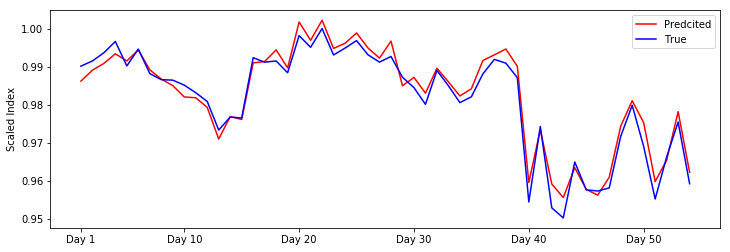

Cumulative return: 0.3301787383192455 | Profitability Performance: 0.9259259259259259 | MSE Loss: 0.00038453443135821885


In [12]:
encoder=EncoderRNN().cuda()
decoder = DecoderRNN().cuda()
encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())
criterion=nn.MSELoss()
    
checkpoint = torch.load('models/OpenPrice/model_947.pth')
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
encoder.eval()
decoder.eval()

eval_loss,y_pred,y_true=test(encoder,decoder, test_loader, criterion)
pred_perf=pp(y_pred,y_true)
daily_returns=cdr(y_pred,y_true)
    
plt.figure(figsize=(12,4))
plt.plot(range(1,len(y_pred)+1),y_pred,color='red',label='Predcited')
plt.plot(range(1,len(y_true)+1),y_true,color='blue',label='True')
plt.ylabel('Scaled Index')
plt.xticks([1,10,20,30,40,50],['Day 1', 'Day 10', 'Day 20', 'Day 30', 'Day 40', 'Day 50'])
plt.legend()
plt.show()
print ('Cumulative return: {} | Profitability Performance: {} | MSE Loss: {}'.format(daily_returns, pred_perf, eval_loss))
    

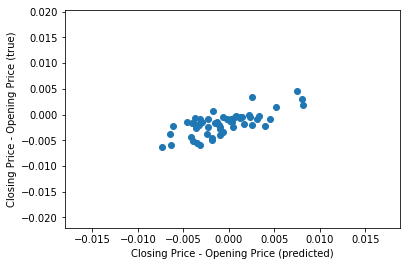

In [17]:
a=test_df['Open Price'].values
a=a[-54:]
plt.scatter(y_pred-a,y_true-a)
plt.ylabel('Closing Price - Opening Price (true)')
plt.xlabel('Closing Price - Opening Price (predicted)')
plt.show()

In [16]:
np.corrcoef(y_pred-a,y_true-a)

array([[1.        , 0.72497275],
       [0.72497275, 1.        ]])